# RAPIDS CuPy

Install cupy if needed with the following command lines

In [ ]:
# !apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
# !ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
# !pip install cupy-cuda110

# import cupy as cp

Unfortunately, cupy doesn't work without a NVIDIA GPU (which most of Mac computers don't have)

### Imports

In [1]:
import numpy as np
import pandas as pd
import cupy as cp
from time import time
import matplotlib.pyplot as plt
from math import *
from scipy.stats import norm

## Autocall pricing

### Autocall explanation with stock prices generation

Called at year 1 : $\mathit{payoff} = \frac{100 * (1 + \mathit{coupon})}{1 + r_f}$

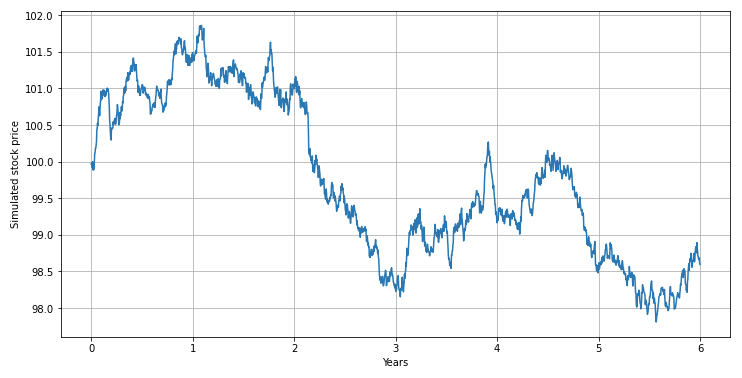

Called at year 3 : $\mathit{payoff} = \frac{100 * (1 + 3 * \mathit{coupon})}{(1 + r_f)^3}$

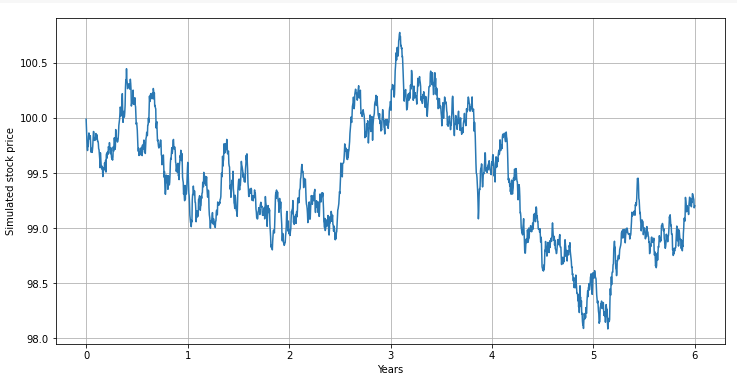

Called at year 5 : $\mathit{payoff} = \frac{100 * (1 + 5 * \mathit{coupon})}{(1 + r_f)^5}$

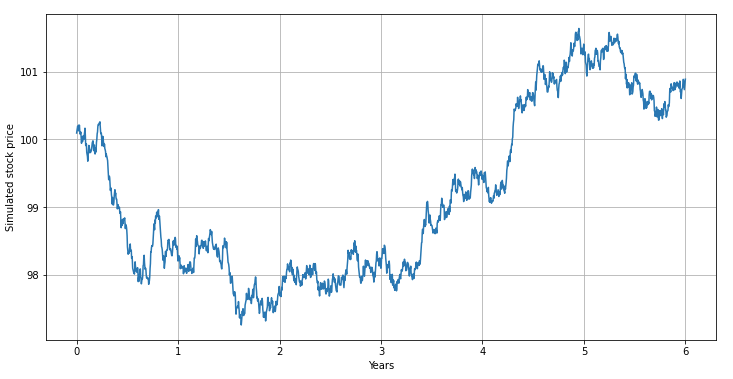

Not called and fully reimbursed at maturity (barrier at 95%) : $\mathit{payoff} = \frac{100}{(1 + r_f)^6}$

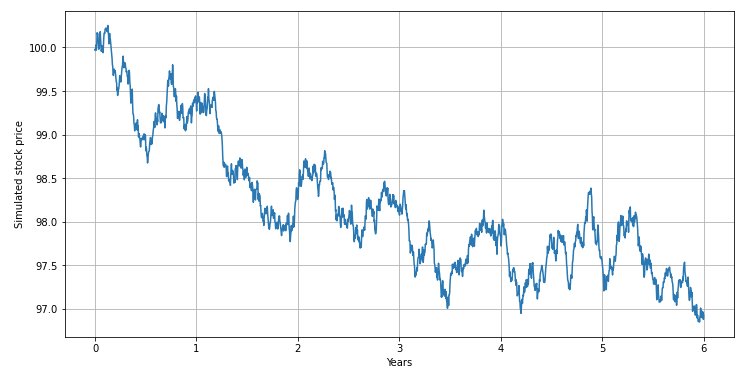

Not called and partially reimbursed at maturity (barrier at 95%) : $\mathit{payoff} = \frac{\mathit{price_{maturity}}}{(1 + rf)^6}$

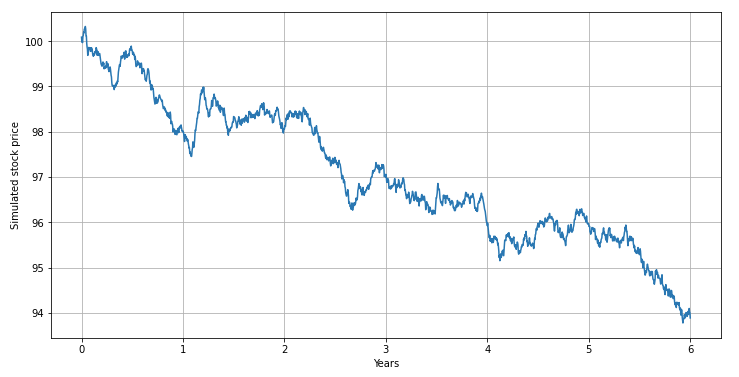

Some simulated examples

In [2]:
def display_stock_price(nbr_stocks, r, sigma, years, n_days_per_year, price0):
  delta_t = years / (years * n_days_per_year)
  plt.figure(figsize=(12, 6))
  for i in range(nbr_stocks):
    returns = (r - sigma**2 / 2) * delta_t + np.random.normal(0, 1, (years + 1) * n_days_per_year) * sigma * delta_t
    prices = price0 * np.cumprod(np.exp(returns))
    plt.plot(np.linspace(0, years, (years + 1) * n_days_per_year), prices)
  plt.xlabel("Years")
  plt.ylabel("Simulated stock price")
  plt.grid()

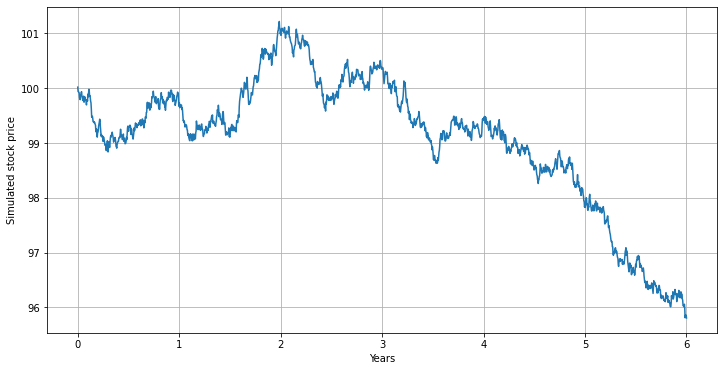

In [3]:
display_stock_price(1, 0.01, 0.15, 6, 250, 100)

### Pricing function

In [4]:
def autocall_pricing(cp_or_np, n, r, sigma, maturity, price0, strike, coupon, barrier):
  S = cp_or_np.zeros((n))
  S[:] = price0
  price = 0
  for i in range(maturity):
    S[:] = S[:] * cp_or_np.exp((r - 0.5 * sigma**2) + sigma * cp_or_np.random.randn(len(S)))
    autocalled = S[S > strike]
    price += len(autocalled) * (price0 + coupon) / (1 + r)**(i + 1)
    S = S[S < price0]
  S_mid = S[S >= barrier]
  S_low = S[S < barrier]
  price += len(S_mid) * price0 / (1 + r)**maturity
  price += cp_or_np.sum(S_low) / (1 + r)**maturity
  price = price / n
  return price

### Running some pricing simulations

Parameters

In [9]:
r        = 0.01    # risk-free rate
sigma    = 0.10    # volatility of the simulated stocks
maturity = 8       # maturity of the autocall
price0   = 100     # price of the stocks at time 0
strike   = 100     # Strike price of the autocall
coupon   = 0.08    # coupon value when the autocall is called
barrier  = 0.8     # barrier when the autocall goes to maturity
n        = 10**7   # Number of simulated stocks

With Numpy

In [10]:
%%time
autocall_pricing(np, n, r, sigma, maturity, price0, strike, coupon, barrier)

Wall time: 1.95 s


97.19478956786489

With CuPy

In [11]:
%%time
autocall_pricing(cp, n, r, sigma, maturity, price0, strike, coupon, barrier)

Wall time: 120 ms


array(97.19339942)

### Ploting time spent w.r.t. the number of stocks simulated

In [12]:
# Builds the array of times spent to calculate the autocall price...
# ...with a number of simulated stocks ranging in the indexes array
# It uses either the numpy library if cp_or_np = np or the cupy library
def build_times(cp_or_np, r, sigma, maturity, price0, strike, coupon, barrier, indexes):
    times = np.array([])
    for x in indexes:
        start = time()
        autocall_pricing(cp_or_np, int(x), r, sigma, maturity, price0, strike, coupon, barrier)
        times = np.append(times, [time() - start])
    return times

Text(0, 0.5, 'Time in seconds')

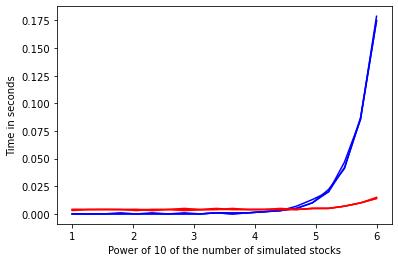

In [15]:
nbr_times = 20
max_power = 6
x_axis = np.power(np.ones((nbr_times)) * 10, np.linspace(1, max_power, nbr_times))
for i in range(3):
  plt.plot(np.log10(x_axis), build_times(np, r, sigma, maturity, price0, strike, coupon, barrier, x_axis), c = "b")
for i in range(3):
  plt.plot(np.log10(x_axis), build_times(cp, r, sigma, maturity, price0, strike, coupon, barrier, x_axis), c = "r")
plt.xlabel("Power of 10 of the number of simulated stocks")
plt.ylabel("Time in seconds")

Text(0, 0.5, 'Time in seconds')

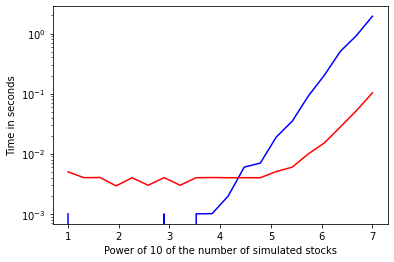

In [16]:
nbr_times = 20
max_power = 7
plt.yscale('log')
x_axis = np.power(np.ones((nbr_times)) * 10, np.linspace(1, max_power, nbr_times))
for i in range(1):
  plt.plot(np.log10(x_axis), build_times(np, r, sigma, maturity, price0, strike, coupon, barrier, x_axis), c = "b")
for i in range(1):
  plt.plot(np.log10(x_axis), build_times(cp, r, sigma, maturity, price0, strike, coupon, barrier, x_axis), c = "r")

plt.xlabel("Power of 10 of the number of simulated stocks")
plt.ylabel("Time in seconds")


## Ploting some interesting results

### Price of the autocall as a function of the volatility of the underlying

Parameters

In [13]:
r        = 0.01    # risk-free rate
maturity = 8       # maturity of the autocall
price0   = 100     # price of the stocks at time 0
strike   = 100     # Strike price of the autocall
coupon   = 0.08    # coupon value when the autocall is called
barrier  = 0.8     # barrier when the autocall goes to maturity
n        = 10**6   # Number of simulated stocks

np_sigmas = np.linspace(0.01, 1, 20)  # Range of volatilities
cp_sigmas = cp.linspace(0.01, 1, 20)  # Range of volatilities

With Numpy

Wall time: 4.53 s


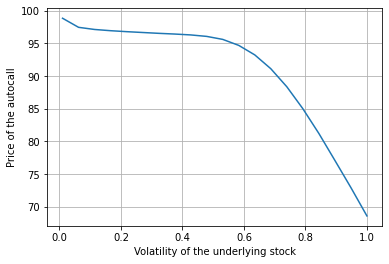

In [14]:
%%time
prices = np.array([autocall_pricing(np, n, r, x, maturity, price0, strike, coupon, barrier) for x in np_sigmas])
plt.plot(np_sigmas, prices)
plt.xlabel("Volatility of the underlying stock")
plt.ylabel("Price of the autocall")
plt.grid()

With CuPy

Wall time: 454 ms


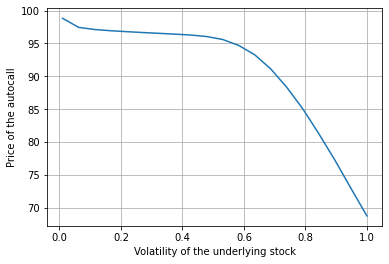

In [15]:
%%time
prices = cp.array([autocall_pricing(cp, n, r, x, maturity, price0, strike, coupon, barrier) for x in cp_sigmas])
plt.plot(cp.asnumpy(cp_sigmas), cp.asnumpy(prices))
plt.xlabel("Volatility of the underlying stock")
plt.ylabel("Price of the autocall")
plt.grid()

### Price of the autocall as a function of the risk-free rate

Parameters

In [17]:
sigma    = 0.1     # volatility of the underlying stock
maturity = 8       # maturity of the autocall
price0   = 100     # price of the stocks at time 0
strike   = 100     # Strike price of the autocall
coupon   = 0.08    # coupon value when the autocall is called
barrier  = 0.8     # barrier when the autocall goes to maturity
n        = 10**6   # Number of simulated stocks

np_rates = np.linspace(0.005, 0.05, 15)  # Range of rates
cp_rates = cp.linspace(0.005, 0.05, 15)  # Range of rates

With Numpy

Wall time: 2.17 s


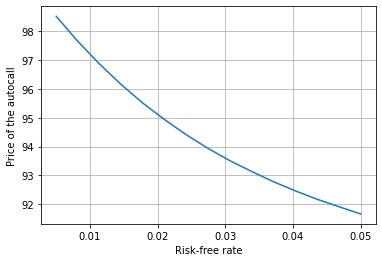

In [18]:
%%time
prices = np.array([autocall_pricing(np, n, r, sigma, maturity, price0, strike, coupon, barrier) for r in np_rates])
plt.plot(np_rates, prices)
plt.xlabel("Risk-free rate")
plt.ylabel("Price of the autocall")
plt.grid()

With CuPy

Wall time: 239 ms


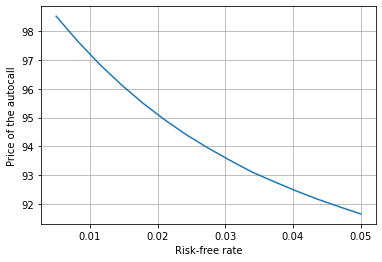

In [19]:
%%time
prices = cp.array([autocall_pricing(cp, n, r, sigma, maturity, price0, strike, coupon, barrier) for r in cp_rates])
plt.plot(cp.asnumpy(cp_rates), cp.asnumpy(prices))
plt.xlabel("Risk-free rate")
plt.ylabel("Price of the autocall")
plt.grid()